**Imports Relevant Packages**

In [ ]:
!pip install beautifulsoup4
!pip install requests
!pip install timezonefinder
!pip install geopy

from bs4 import BeautifulSoup
import requests
import shutil
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
from datetime import timedelta
from timezonefinder import TimezoneFinder
from pytz import timezone

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.7 MB/s eta 0:00:00
  Created wheel for timezonefinder: filename=timezonefinder-6.2.0-cp310-cp310-manylinux_2_35_x86_64.whl size=46900633 sha256=5f7ad2fd600d9d8bb49e94fab3efb2ce01eea52065ffbcf0c8eaec461c79651b
  Stored in directory: /root/.cache/pip/wheels/17/19/d4/ae94459b7f74f7e8f171862d1c08adedf9b7c76ddfc514a620
Successfully built timezonefinder


**Mounts local Google drive onto Colab notebook**

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


**Reads data from website, saves as text file, then loads website data from saved text file and assigns it to a Pandas dataframe**

In [ ]:
#Input parameters
dt_initial = '20230626'         #starting date YYYYMMDD format
dt_final = '20230630'           #final date YYYYMMDD format
season = 'spring'               #Available choices: spring, summer, autumn, winter, all
level = 1.5                     #AERONET data level
site = 'Tel-Aviv_University'                   #AERONET location
wavelength = 500                #Available choices: 1640, 1020, 870, 865, 779, 675, 667, 620, 560, 555, 551, 532, 531, 510, 500, 490, 443, 440, 412, 400, 380, 340
Angstrom_exp = '440-870'        #Available choices: '440-870','380-500','440-675','500-870','340-440','440-675'

#Reads data from website with user parameters, saves as text file,
#then loads website data from saved text file and assigns it to a Pandas dataframe

yr_initial = dt_initial[:4]               #initial year
mon_initial = dt_initial[4:6]             #initial month
day_initial = dt_initial[6:]              #initial day

yr_final = dt_final[:4]                   #final year
mon_final = dt_final[4:6]                 #final month
day_final = dt_final[6:]                  #final day

if level == 1 or level == 1.0:
  level = 10
elif level == 1.5:
  level = 15
elif level == 2 or level == 2.0:
  level = 20

base_web = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=',site,'&year=',yr_initial,'&month=',mon_initial,'&day=',day_initial,'&year2=',yr_final,'&month2=',mon_final,'&day2=',day_final,'&AOD',level,'=1&AVG=10'

def convertTuple(tup):
  st = ''.join(map(str, tup))
  return st

url = convertTuple(base_web)
soup = BeautifulSoup(requests.get(url).text)

if len(soup) <= 1:
  site = 'GSFC'
  print("\nThe link could not be generated due to issues with the input. Using system defaults...")
  print("Site: GSFC. Level: 2.0. Dates: 2000-01-01 to 2022-12-31")
  base_web = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=GSFC&year=2000&month=01&day=01&year2=2022&month2=12&day2=31&AOD20=1&AVG=10'
  url = convertTuple(base_web)
  soup = BeautifulSoup(requests.get(url).text)

with open(r'/content/sample_data/Test.txt' ,"w") as oFile:
  oFile.write(str(soup.text))
  oFile.close()

**Data processing - Time**

In [ ]:
df = pd.read_csv(r'/content/sample_data/Test.txt',skiprows = 5) #reads data into Pandas dataframe
df = df.replace(-999.0, np.nan)             #replaces all -999.9 values with NaN so that averages are properly calculated

df[['Day','Month','Year']] = df['Date(dd:mm:yyyy)'].str.split(':',expand=True)                            #splits Date column into separate columns
df['Date'] = df[['Year','Month','Day']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")   #joins those columns back in a different format
df['Date']= pd.to_datetime(df['Date'])                                                                    #converts Date column to datetime format for easier manipulation

def tz_diff(date, tz1, tz2):              #Returns the difference in hours between timezone1 and timezone2 for a given date.
  date = pd.to_datetime(date)
  return (tz1.localize(date) -
            tz2.localize(date).astimezone(tz1))\
            .seconds/3600

diff = tz_diff('2000-01-01',timezone('UTC'), timezone(TimezoneFinder().timezone_at(lng=pd.unique(df[['Site_Longitude(Degrees)']].values.ravel('K'))[0],
                                            lat=pd.unique(df[['Site_Latitude(Degrees)']].values.ravel('K'))[0])))    #computes the time difference between site and GMT based on coordinates
if diff > 12:
  diff = diff-24          #this correction converts time difference range from 0-24 hours to [-12, +12] hours

df.insert(3,"Time_Diff", diff)                                       #inserts blank column that will store the computed time difference between GMT and the local time at that location

df['Time(hh:mm:ss)'] = pd.to_datetime(df['Time(hh:mm:ss)'],infer_datetime_format=True).apply(lambda d:d.time()) #converts time column from string to timestamp, keeping just the hours
df['GMT'] = df.apply(lambda x : pd.datetime.combine(x['Date'],x['Time(hh:mm:ss)']),1)          #combines date and time together into one timestamp in GMT

df.insert(1,"LST", 0)     #Inserts a new local time column
for i in range(len(df)):
  df['LST'][i] = df['GMT'][i] + timedelta(hours = int(df['Time_Diff'][i]))   #calculates local standard time based on time zone difference from GMT

**Calculating Local Solar Time**

In [ ]:
#local solar time = local standard time (daylight savings not included) + 4*(Lst - Lloc) + E
#E = 229.2(0.000075 + 0.001868 𝑐𝑜𝑠 𝐵 − 0.032077 𝑠𝑖𝑛 𝐵 − 0.014615 𝑐𝑜𝑠 2𝐵 − 0.04089 𝑠𝑖𝑛 2𝐵); can also be interpolated graphically
#B = (n-1)*(360/365)       where n is day of the year 1<=n<=365

#Lst is the standard meridian for the local time zone, calculated as x*15,
#where 'x' is the hour difference between GMT and local standard time, and 15 is the number of degrees corresponding per hour.

#Lloc is the longitude of the location in question

#E is the equation of time in minutes

#Source: https://faculty.eng.ufl.edu/jonathan-scheffe/wp-content/uploads/sites/100/2020/08/Solar-Time1419.pdf

df['B'] = np.nan
for i in range(len(df)):                                      #calculates B parameter
  df['B'][i] = (df['Day_of_Year'][i]-1)*(360/365)

df['E'] = np.nan
for i in range(len(df)):                                      #calculates equation of time in minutes
  df['E'][i] = 229.2*(0.000075 + 0.001868*math.cos(df['B'][i]) - 0.032077*math.sin(df['B'][i]) - 0.014615*math.cos(2*df['B'][i]) - 0.04089*math.sin(2*df['B'][i]))

df['Lst'] = np.nan
for i in range(len(df)):                                      #calculates standard meridian
  df['Lst'][i] = 15*abs(df['GMT'][i] - df['LST'][i]).total_seconds()/3600

df['Correction'] = np.nan
for i in range(len(df)):                                      #calculates time difference between solar time and local standard time
  df['Correction'][i] = 4*(df['Lst'][i] - abs(df['Site_Longitude(Degrees)'][i])) + df['E'][i]

df['Timestamp (solar)'] = np.nan
for i in range(len(df)):                                      #calculates local solar time as datetime stamp
  df['Timestamp (solar)'][i] = (df['LST'][i] + timedelta(hours=0, minutes=df['Correction'][i])).strftime("%Y-%m-%d %H:%M:%S")

**Creating the hourly bins**

In [ ]:
df['Date_Solar'] = pd.to_datetime(df['Timestamp (solar)']).dt.date  #converts solar timestamp column to datetime format for manipulation
df['Hour'] = np.nan                                               #Creates new Hour colum

for i in range(len(df)):
  df['Hour'][i] = df['GMT'][i].strftime('%H:%M:%S')   #isolates the hours, minutes and seconds from the solar timestamp
  df['Hour'][i] = df['Hour'][i][:-6]                                #populates new Hour column with the times by truncating the last 6 characters of the old time column, leaving just the hour

df = df[['Date_Solar','Hour','Time(hh:mm:ss)','AOD_'+str(wavelength)+'nm',Angstrom_exp+'_Angstrom_Exponent','Precipitable_Water(cm)']]    #isolates all the columns of interest
df = df.rename(columns={"Date_Solar": "Date", "Time(hh:mm:ss)": "Time"})
df['Daily_Occurence'] = df.groupby('Date')['Date'].transform('size')              #creates new Daily Occurence column, which counts number of records for each day
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Hour,Time,AOD_500nm,440-870_Angstrom_Exponent,Precipitable_Water(cm),Daily_Occurence
0,2023-01-01,17,17:40:05,0.008986,0.831193,0.178075,108
1,2023-01-01,17,17:43:09,0.008883,0.810218,0.174256,108
2,2023-01-01,17,17:46:26,0.008612,0.844331,0.174983,108
3,2023-01-01,17,17:48:22,0.008570,0.825788,0.175125,108
4,2023-01-01,17,17:51:01,0.008613,0.823299,0.174932,108
...,...,...,...,...,...,...,...
11963,2023-07-27,22,22:59:18,0.018428,1.052314,0.415191,72
11964,2023-07-27,23,23:04:18,0.019801,1.128932,0.444846,72
11965,2023-07-27,23,23:09:18,0.023383,1.151475,0.473617,72
11966,2023-07-27,23,23:14:18,0.021090,1.131022,0.451829,72


**Season Selection**

In [ ]:
df['Season'] = (df['Date'].dt.month - 1) // 3
if season == 'winter':
  df = df.loc[df['Season'] == 0]
elif season == 'spring':
  df = df.loc[df['Season'] == 1]
elif season == 'summer':
  df = df.loc[df['Season'] == 2]
elif season == 'autumn' or season == 'fall':
  df = df.loc[df['Season'] == 3]
df = df.drop(columns = ['Season']).reset_index(drop=True)
df

,Date,Hour,Time,AOD_500nm,440-870_Angstrom_Exponent,Precipitable_Water(cm),Daily_Occurence
0,2023-04-01,17,17:52:49,0.022416,1.231027,0.543092,52
1,2023-04-01,18,18:02:10,0.021888,1.225390,0.520714,52
2,2023-04-01,18,18:04:08,0.022047,1.218302,0.514519,52
3,2023-04-01,18,18:06:06,0.021837,1.234377,0.505297,52
4,2023-04-01,18,18:12:01,0.021278,1.218093,0.511748,52
...,...,...,...,...,...,...,...
4992,2023-06-29,04,04:08:48,0.016422,1.005841,0.138378,129
4993,2023-06-29,04,04:10:45,0.016629,1.020915,0.131055,129
4994,2023-06-29,04,04:13:06,0.016414,1.004145,0.123563,129
4995,2023-06-29,04,04:16:15,0.016792,1.032592,0.128622,129


**Visualizing how many measurements are taken per day. It appears that most commonly, there are 50-60 daily measurements at GSFC.**

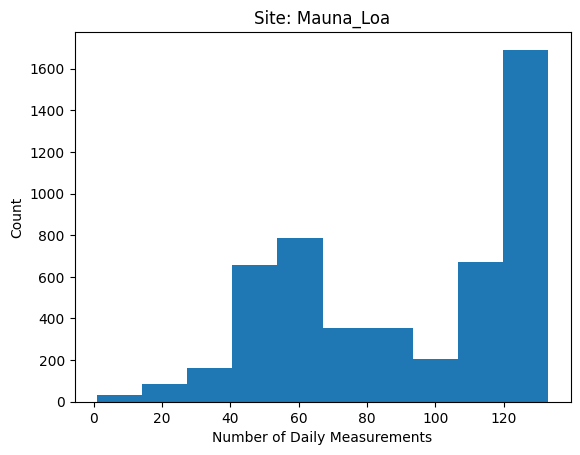

In [ ]:
plt.hist(df['Daily_Occurence'])
plt.xlabel('Number of Daily Measurements')
plt.ylabel('Count')
plt.title("Site: "+str(site))
plt.show()

**If number of measurements per day >10 compute Daily Average (e.g., AOD_500, AE (440-870), WVC)**

In [ ]:
df_averaged = df[df['Daily_Occurence'] >= 10]    #creates new dataframe that only contains records having more than 10 occurrences per day
df_averaged = df_averaged.reset_index(drop = True).drop(columns='Daily_Occurence') #resets index and removes Daily Occurence column

df_daily = df.groupby('Date').mean().reset_index().drop(columns='Daily_Occurence')        #creates a new dataframe with just daily averages, whose values will be used to compute absolute differences
df_daily = df_daily.rename(columns={'AOD_'+str(wavelength)+'nm':'AOD_'+str(wavelength)+'nm_Daily',Angstrom_exp+'_Angstrom_Exponent':Angstrom_exp+'_Angstrom_Exponent_Daily','Precipitable_Water(cm)':'Precipitable_Water(cm)_Daily'})

df_combined = pd.merge(df_averaged, df_daily, on='Date')              #merges daily data frame with the concatenated dataframe from above
df_combined

,Date,Hour,Time,AOD_500nm,440-870_Angstrom_Exponent,Precipitable_Water(cm),AOD_500nm_Daily,440-870_Angstrom_Exponent_Daily,Precipitable_Water(cm)_Daily
0,2023-04-01,17,17:52:49,0.022416,1.231027,0.543092,0.023228,1.061304,0.529036
1,2023-04-01,18,18:02:10,0.021888,1.225390,0.520714,0.023228,1.061304,0.529036
2,2023-04-01,18,18:04:08,0.022047,1.218302,0.514519,0.023228,1.061304,0.529036
3,2023-04-01,18,18:06:06,0.021837,1.234377,0.505297,0.023228,1.061304,0.529036
4,2023-04-01,18,18:12:01,0.021278,1.218093,0.511748,0.023228,1.061304,0.529036
...,...,...,...,...,...,...,...,...,...
4975,2023-06-29,04,04:08:48,0.016422,1.005841,0.138378,0.013850,0.937869,0.145822
4976,2023-06-29,04,04:10:45,0.016629,1.020915,0.131055,0.013850,0.937869,0.145822
4977,2023-06-29,04,04:13:06,0.016414,1.004145,0.123563,0.013850,0.937869,0.145822
4978,2023-06-29,04,04:16:15,0.016792,1.032592,0.128622,0.013850,0.937869,0.145822


**For each hourly bin compute absolute differences, instantaneous values minus daily average (e.g., for AOD_500, AE(440-870), WVC)**

In [ ]:
df_combined['Absolute_Diff_AOD'+str(wavelength)] = np.nan               #creates three blank columns, which represent the absolute differences for AOD 500, 440-870 Angstrom, WVC
df_combined['Absolute_Diff_'+str(Angstrom_exp)] = np.nan
df_combined['Absolute_Diff_WVC'] = np.nan

for i in range(len(df_combined)):      #calculates absolute differences between instantaneous (hourly) bins and daily values.
    df_combined['Absolute_Diff_AOD'+str(wavelength)][i] = df_combined['AOD_'+str(wavelength)+'nm'][i] - df_combined['AOD_'+str(wavelength)+'nm_Daily'][i]
    df_combined['Absolute_Diff_'+str(Angstrom_exp)][i] = df_combined[Angstrom_exp+'_Angstrom_Exponent'][i] - df_combined[Angstrom_exp+'_Angstrom_Exponent_Daily'][i]
    df_combined['Absolute_Diff_WVC'][i] = df_combined['Precipitable_Water(cm)'][i] - df_combined['Precipitable_Water(cm)_Daily'][i]

df_combined

,Date,Hour,Time,AOD_500nm,440-870_Angstrom_Exponent,Precipitable_Water(cm),AOD_500nm_Daily,440-870_Angstrom_Exponent_Daily,Precipitable_Water(cm)_Daily,Absolute_Diff_AOD500,Absolute_Diff_440-870,Absolute_Diff_WVC
0,2023-04-01,17,17:52:49,0.022416,1.231027,0.543092,0.023228,1.061304,0.529036,-0.000812,0.169723,0.014056
1,2023-04-01,18,18:02:10,0.021888,1.225390,0.520714,0.023228,1.061304,0.529036,-0.001340,0.164086,-0.008322
2,2023-04-01,18,18:04:08,0.022047,1.218302,0.514519,0.023228,1.061304,0.529036,-0.001181,0.156998,-0.014517
3,2023-04-01,18,18:06:06,0.021837,1.234377,0.505297,0.023228,1.061304,0.529036,-0.001391,0.173073,-0.023739
4,2023-04-01,18,18:12:01,0.021278,1.218093,0.511748,0.023228,1.061304,0.529036,-0.001950,0.156789,-0.017288
...,...,...,...,...,...,...,...,...,...,...,...,...
4975,2023-06-29,04,04:08:48,0.016422,1.005841,0.138378,0.013850,0.937869,0.145822,0.002572,0.067972,-0.007444
4976,2023-06-29,04,04:10:45,0.016629,1.020915,0.131055,0.013850,0.937869,0.145822,0.002779,0.083046,-0.014767
4977,2023-06-29,04,04:13:06,0.016414,1.004145,0.123563,0.013850,0.937869,0.145822,0.002564,0.066276,-0.022259
4978,2023-06-29,04,04:16:15,0.016792,1.032592,0.128622,0.013850,0.937869,0.145822,0.002942,0.094723,-0.017200


**Old algorithm - DO NOT EXECUTE**

In [ ]:
df_combined['Hour'] = df_combined['Hour'].astype(int)                  #converts hourly bin column to integer
df_combined.insert(0,"N_Diff",1)
df_N_diff = df_combined[['N_Diff','Hour']]
df_N_diff = df_N_diff.groupby(['Hour'])['N_Diff'].sum().reset_index()

df_combined = df_combined.drop(columns=['Date','N_Diff'])

df_stdev = df_combined.groupby(['Hour'])['Absolute_Diff_AOD'+str(wavelength),'Absolute_Diff_'+str(Angstrom_exp),'Absolute_Diff_WVC'].std().reset_index()    #groups by Date and Hour, computes standard dev of differences for each hourly bin
df_stdev = df_stdev.rename(columns={'Absolute_Diff_AOD'+str(wavelength):'AOD_'+str(wavelength)+'nm_Sigma','Absolute_Diff_'+str(Angstrom_exp):Angstrom_exp+'_Sigma','Absolute_Diff_WVC':'WVC_Sigma'})       #renames columns to reflect them being stdev "sigma" columns

df_miu = df_combined.groupby(['Hour'])['Absolute_Diff_AOD'+str(wavelength),'Absolute_Diff_'+str(Angstrom_exp),'Absolute_Diff_WVC'].mean().reset_index()      #groups by Date and Hour, computes means of differences for each hourly bin
df_miu = df_miu.rename(columns={'Absolute_Diff_AOD'+str(wavelength):'AOD_'+str(wavelength)+'nm_Miu','Absolute_Diff_'+str(Angstrom_exp):Angstrom_exp+'_Miu','Absolute_Diff_WVC':'WVC_Miu'})        #renames columns to reflect them being mean "miu" columns

df_statistics = pd.merge(df_stdev, df_miu)        #combines the average and standard devition of differences columns into a combined dataframe df_statistics

df_final = df_statistics.drop_duplicates()
df_diurnal = pd.merge(df_final,df_N_diff)
df_diurnal.to_excel(r'/content/sample_data/Output_'+str(site)+'_Original.xlsx',index=False)   #saves table as Excel file

**For each hourly bin compute mean of those differences and corresponding standard deviations**

In [ ]:
df_stdev = df_combined.groupby(['Date','Hour'])['Absolute_Diff_AOD'+str(wavelength),'Absolute_Diff_'+str(Angstrom_exp),'Absolute_Diff_WVC'].std().reset_index()    #groups by Date and Hour, computes standard dev of differences for each hourly bin
df_stdev = df_stdev.rename(columns={'Absolute_Diff_AOD'+str(wavelength):'AOD_'+str(wavelength)+'nm_Sigma','Absolute_Diff_'+str(Angstrom_exp):Angstrom_exp+'_Sigma','Absolute_Diff_WVC':'WVC_Sigma'})       #renames columns to reflect them being stdev "sigma" columns

df_miu = df_combined.groupby(['Date','Hour'])['Absolute_Diff_AOD'+str(wavelength),'Absolute_Diff_'+str(Angstrom_exp),'Absolute_Diff_WVC'].mean().reset_index()      #groups by Date and Hour, computes means of differences for each hourly bin
df_miu = df_miu.rename(columns={'Absolute_Diff_AOD'+str(wavelength):'AOD_'+str(wavelength)+'nm_Miu','Absolute_Diff_'+str(Angstrom_exp):Angstrom_exp+'_Miu','Absolute_Diff_WVC':'WVC_Miu'})        #renames columns to reflect them being mean "miu" columns

df_statistics = pd.merge(df_stdev, df_miu)        #combines the average and standard devition of differences columns into a combined dataframe df_statistics
df_statistics

,Date,Hour,AOD_500nm_Sigma,440-870_Sigma,WVC_Sigma,AOD_500nm_Miu,440-870_Miu,WVC_Miu
0,2023-04-01,17,NaN,NaN,NaN,-0.000812,0.169723,0.014056
1,2023-04-01,18,0.000785,0.036198,0.005360,-0.001950,0.137470,-0.020043
2,2023-04-01,19,0.007795,0.292189,0.016469,0.005773,-0.216393,-0.069354
3,2023-04-01,20,0.006678,0.228024,0.032513,0.003036,-0.127140,-0.014852
4,2023-04-01,21,0.000630,0.075105,0.023203,-0.002740,0.095472,0.007783
...,...,...,...,...,...,...,...,...
606,2023-06-29,19,0.000163,0.034736,0.002085,-0.002381,-0.059658,-0.083974
607,2023-06-29,20,0.000628,0.050038,0.002547,-0.001265,-0.043560,-0.080202
608,2023-06-29,21,0.000471,0.077803,0.010978,0.000456,-0.002683,-0.069703
609,2023-06-29,22,0.000382,0.041887,0.071778,0.000376,-0.027718,0.013720


**Final Table should look like this**

In [ ]:
df_final = pd.merge(df_combined, df_statistics, how="outer")     #combines statistics dataset with combined data and differences. Does an outer join so that all records are kept
df_final = df_final.fillna(0)                                    #fills remaining NaNs with zeroes. Any zero indicates that there was only 1 record for a particular hourly bin and/or day so a calculated average
df_final['Hour'] = df_final['Hour'].astype(int).astype(str)      #cuts zero from hourly bin column and then converts to string
df_final

,Date,Hour,Time,AOD_500nm,440-870_Angstrom_Exponent,Precipitable_Water(cm),AOD_500nm_Daily,440-870_Angstrom_Exponent_Daily,Precipitable_Water(cm)_Daily,Absolute_Diff_AOD500,Absolute_Diff_440-870,Absolute_Diff_WVC,AOD_500nm_Sigma,440-870_Sigma,WVC_Sigma,AOD_500nm_Miu,440-870_Miu,WVC_Miu
0,2023-04-01,17,17:52:49,0.022416,1.231027,0.543092,0.023228,1.061304,0.529036,-0.000812,0.169723,0.014056,0.000000,0.000000,0.000000,-0.000812,0.169723,0.014056
1,2023-04-01,18,18:02:10,0.021888,1.225390,0.520714,0.023228,1.061304,0.529036,-0.001340,0.164086,-0.008322,0.000785,0.036198,0.005360,-0.001950,0.137470,-0.020043
2,2023-04-01,18,18:04:08,0.022047,1.218302,0.514519,0.023228,1.061304,0.529036,-0.001181,0.156998,-0.014517,0.000785,0.036198,0.005360,-0.001950,0.137470,-0.020043
3,2023-04-01,18,18:06:06,0.021837,1.234377,0.505297,0.023228,1.061304,0.529036,-0.001391,0.173073,-0.023739,0.000785,0.036198,0.005360,-0.001950,0.137470,-0.020043
4,2023-04-01,18,18:12:01,0.021278,1.218093,0.511748,0.023228,1.061304,0.529036,-0.001950,0.156789,-0.017288,0.000785,0.036198,0.005360,-0.001950,0.137470,-0.020043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4975,2023-06-29,4,04:08:48,0.016422,1.005841,0.138378,0.013850,0.937869,0.145822,0.002572,0.067972,-0.007444,0.000195,0.014896,0.006028,0.002765,0.082154,-0.014165
4976,2023-06-29,4,04:10:45,0.016629,1.020915,0.131055,0.013850,0.937869,0.145822,0.002779,0.083046,-0.014767,0.000195,0.014896,0.006028,0.002765,0.082154,-0.014165
4977,2023-06-29,4,04:13:06,0.016414,1.004145,0.123563,0.013850,0.937869,0.145822,0.002564,0.066276,-0.022259,0.000195,0.014896,0.006028,0.002765,0.082154,-0.014165
4978,2023-06-29,4,04:16:15,0.016792,1.032592,0.128622,0.013850,0.937869,0.145822,0.002942,0.094723,-0.017200,0.000195,0.014896,0.006028,0.002765,0.082154,-0.014165


**Creating Diurnal Plots**

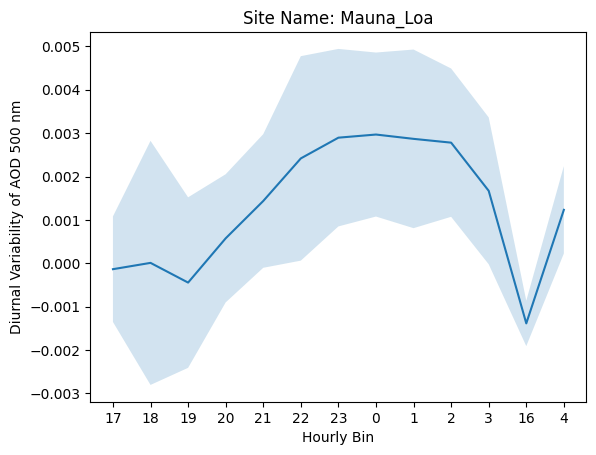

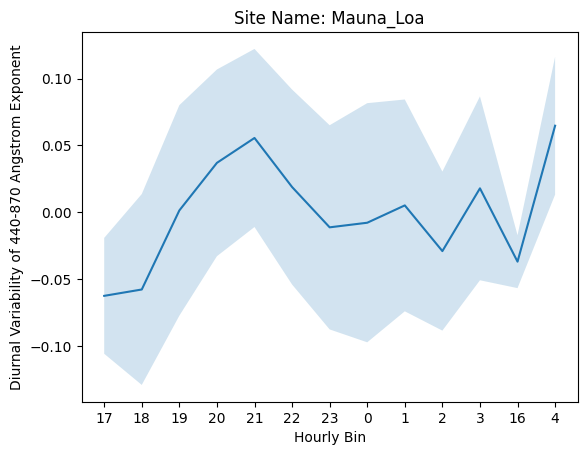

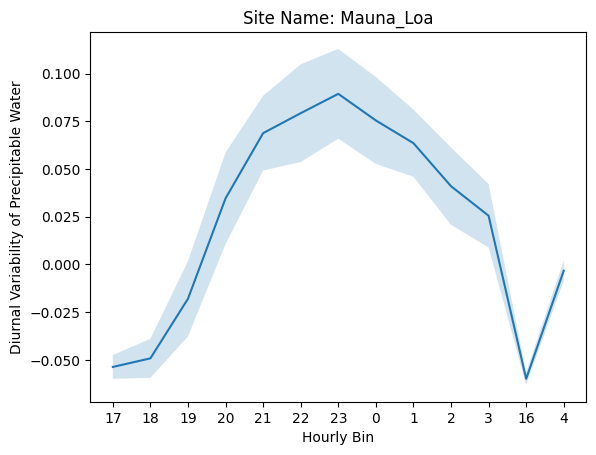

In [ ]:
df_final = df_final[['Hour','AOD_'+str(wavelength)+'nm_Sigma',Angstrom_exp+'_Sigma','WVC_Sigma','AOD_'+str(wavelength)+'nm_Miu',Angstrom_exp+'_Miu','WVC_Miu']]
df_final = df_final.drop_duplicates()
df_final.insert(7,"N_Diff",1)
df_N_Diff = df_final.groupby(['Hour'])['N_Diff'].sum().reset_index() #sums all number of differences per given hour
df_final = df_final.drop(columns=['N_Diff'])
df_final = df_final.groupby(['Hour'],sort=False).mean().reset_index()   #takes average of all means and standard deviations per given hour
df_diurnal = pd.merge(df_final,df_N_Diff)
df_diurnal.to_excel(r'/content/sample_data/Output_'+str(site)+'.xlsx',index=False)   #saves table as Excel file

plt.plot(df_diurnal['Hour'], df_diurnal['AOD_'+str(wavelength)+'nm_Miu'])
plt.xlabel('Hourly Bin')
plt.ylabel('Diurnal Variability of AOD '+str(wavelength)+' nm')
plt.title("Site Name: "+str(site))
plt.fill_between(df_diurnal['Hour'], df_diurnal['AOD_'+str(wavelength)+'nm_Miu']-df_diurnal['AOD_'+str(wavelength)+'nm_Sigma'], df_diurnal['AOD_'+str(wavelength)+'nm_Miu']+df_diurnal['AOD_'+str(wavelength)+'nm_Sigma'], alpha = 0.2)
plt.show()

plt.plot(df_diurnal['Hour'], df_diurnal[Angstrom_exp+'_Miu'])
plt.xlabel('Hourly Bin')
plt.ylabel('Diurnal Variability of '+str(Angstrom_exp)+' Angstrom Exponent')
plt.title("Site Name: "+str(site))
plt.fill_between(df_diurnal['Hour'], df_diurnal[Angstrom_exp+'_Miu']-df_diurnal[Angstrom_exp+'_Sigma'], df_diurnal[Angstrom_exp+'_Miu']+df_diurnal[Angstrom_exp+'_Sigma'], alpha = 0.2)
plt.show()

plt.plot(df_diurnal['Hour'], df_diurnal['WVC_Miu'])
plt.xlabel('Hourly Bin')
plt.ylabel('Diurnal Variability of Precipitable Water')
plt.title("Site Name: "+str(site))
plt.fill_between(df_diurnal['Hour'], df_diurnal['WVC_Miu']-df_diurnal['WVC_Sigma'], df_diurnal['WVC_Miu']+df_diurnal['WVC_Sigma'], alpha = 0.2)
plt.show()